### Subreddits
https://www.reddit.com/r/snowboarding/

https://www.reddit.com/r/skiing/

#### api links
api.pushshift.io/reddit/search/?subreddit=snowboarding

http://api.pushshift.io/reddit/comment/search/?subreddit=skiing

https://github.com/pushshift/api

parameters: https://pushshift.io/api-parameters/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

# Thanks to Hov, he inspired me to create a separate notebook that contained
# my functions so I could import them instead of having them take up so much 
# space
from functions import cvec_df,ski_and_sb_stopword_list,model_confusion_matrix

In [2]:
np.random.seed(42)

## Import Comments

In [3]:
# import data
sb_v_ski = pd.read_csv('./data/sb_v_ski_comment_data_10000.csv',index_col = 0)
sb = pd.read_csv('./data/sb_comment_data_10000.csv',index_col = 0)
ski = pd.read_csv('./data/ski_comment_data_10000.csv',index_col = 0)

In [4]:
pd.set_option('display.max_columns',100)

## Stop Word Lists

In [5]:
# instantiate stopword list
stop_words_list = ski_and_sb_stopword_list()

## Count Vectorizing

In [6]:
# CountVectorize all comments
comment_df = cvec_df(sb_v_ski,'stemmed comments',stop_words_list)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


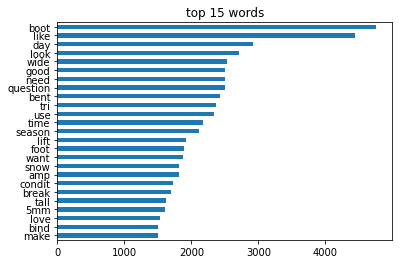

In [7]:
# analyze top 15 words
comment_df.sum().sort_values(ascending = False).head(25).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

### Ski Count Vectorizer

In [8]:
# CountVectorize skiing comments
ski_comment_df = cvec_df(ski,'stemmed comments',stop_words_list)

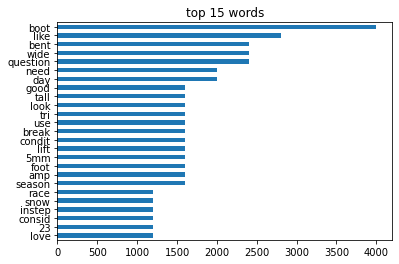

In [9]:
# analyze top 15 words from skiing comments
ski_comment_df.sum().sort_values(ascending = False).head(25).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

### Snowboarding Count Vectorizer

In [10]:
# CountVectorize snowboarding comments
sb_comment_df = cvec_df(sb,'stemmed comments',stop_words_list)

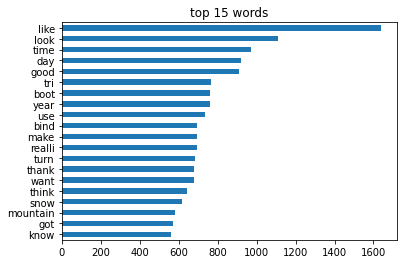

In [11]:
# analyze top 15 words from snowboarding comments
sb_comment_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', title = 'top 15 words')

plt.gca().invert_yaxis();

## Model Set Up

Due to Gridsearch automatically train test splitting data by using cross validation, there is no need so train test split the X and y variables.

Additionally, since there are 9,792 snowboarding comments out of 18,992 total comments after EDA, baseline accuracy is 51.6% if all comments were classified as snowboarding.

In [12]:
# set feature (X) and target (y) variables
X = sb_v_ski['stemmed comments']

y = sb_v_ski['ski or sb']

## Naive Bayes
### Count Vectorizer

In [13]:
# set up Pipeline
nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('nb', MultinomialNB())
])

In [14]:
# set parameters
nb_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(2,2),(3,3),(1,3)],
    'nb__alpha': [0,1]
}

In [15]:
# set up GridSearch
nb_cvec = GridSearchCV(
    estimator = nb_pipe,
    param_grid = nb_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [16]:
# fit GridSearch
nb_cvec.fit(X,y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:  3.9min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will resu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [17]:
# look at best parameters
nb_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'nb__alpha': 0}

In [18]:
# look at best scores
nb_cvec.best_score_

0.951242663703663

In [19]:
# Thanks to Hov I was able to learn about .cv_results_ (I was running a ton
# of different gridsearches prior to that)
nb_cvec_results = pd.DataFrame(nb_cvec.cv_results_)

In [20]:
# look at GridSearch results
nb_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_nb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.633004,0.006408,0.114722,0.004967,0.9,2000,0.01,"(1, 1)",0,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.881021,0.880232,0.882043,0.885993,0.883623,0.882582,0.002048,49
1,0.610881,0.019906,0.122551,0.005673,0.9,2000,0.01,"(1, 1)",1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.881021,0.879968,0.882043,0.885993,0.883623,0.882530,0.002110,57
2,1.243721,0.006010,0.268444,0.007066,0.9,2000,0.01,"(1, 2)",0,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.944459,0.946302,0.947867,0.948131,0.947341,0.946820,0.001336,17
3,1.244886,0.010326,0.264682,0.009005,0.9,2000,0.01,"(1, 2)",1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.945775,0.946302,0.947867,0.949184,0.947341,0.947294,0.001199,9
4,0.970094,0.011834,0.194575,0.017033,0.9,2000,0.01,"(2, 2)",0,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.932614,0.932877,0.934966,0.933123,0.933123,0.933340,0.000834,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.812767,0.009960,0.000000,0.000000,0.95,5000,0.05,"(2, 2)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,260
316,0.816038,0.012708,0.000000,0.000000,0.95,5000,0.05,"(3, 3)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,259
317,0.814414,0.003764,0.000000,0.000000,0.95,5000,0.05,"(3, 3)",1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,258
318,1.567041,0.010266,0.291606,0.007014,0.95,5000,0.05,"(1, 3)",0,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.624901,0.610424,0.615850,0.623749,0.627435,0.620472,0.006343,201


In [21]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
nb_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.951243
0.025    0.677760
0.030    0.665965
0.050    0.620577
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [22]:
# set up Pipeline
nb2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('nb', MultinomialNB())
])

In [23]:
# set parameters
nb2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(2,2),(3,3),(1,3)],
    'nb__alpha': [0,1]
}

In [24]:
# set up GridSearch
nb_tvec = GridSearchCV(
    estimator = nb2_pipe,
    param_grid = nb2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [25]:
# fit GridSearch
nb_tvec.fit(X,y)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   27.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:  3.9min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'heli', 'jumping', 'nordic', 'speed'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [26]:
# look at best parameters
nb_tvec.best_params_

{'nb__alpha': 1,
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [27]:
# look at best scores
nb_tvec.best_score_

0.990522283447835

In [28]:
# turn results into a dataframe
nb_tvec_results = pd.DataFrame(nb_tvec.cv_results_)

In [29]:
# look at GridSearch results
nb_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.506345,0.008995,0.122608,0.004424,0,0.9,2000,0.01,"(1, 1)","{'nb__alpha': 0, 'tvec__max_df': 0.9, 'tvec__m...",0.963938,0.963675,0.958662,0.971301,0.963402,0.964195,0.004051,41
1,1.067025,0.053590,0.216919,0.003127,0,0.9,2000,0.01,"(1, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.9, 'tvec__m...",0.984470,0.982890,0.984729,0.987098,0.983412,0.984520,0.001454,25
2,0.790724,0.009333,0.166527,0.003235,0,0.9,2000,0.01,"(2, 2)","{'nb__alpha': 0, 'tvec__max_df': 0.9, 'tvec__m...",0.932877,0.932877,0.934702,0.933123,0.933386,0.933393,0.000681,49
3,0.803858,0.003154,0.165982,0.002542,0,0.9,2000,0.01,"(3, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.9, 'tvec__m...",0.873651,0.873651,0.873618,0.872828,0.873354,0.873420,0.000316,65
4,1.544520,0.020506,0.307154,0.005731,0,0.9,2000,0.01,"(1, 3)","{'nb__alpha': 0, 'tvec__max_df': 0.9, 'tvec__m...",0.990261,0.989471,0.988942,0.990521,0.987888,0.989417,0.000948,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.519980,0.007049,0.121384,0.002525,1,0.95,5000,0.05,"(1, 1)","{'nb__alpha': 1, 'tvec__max_df': 0.95, 'tvec__...",0.675441,0.661490,0.663507,0.680621,0.677988,0.671810,0.007803,177
316,1.082567,0.014215,0.219584,0.006743,1,0.95,5000,0.05,"(1, 2)","{'nb__alpha': 1, 'tvec__max_df': 0.95, 'tvec__...",0.675441,0.661490,0.663507,0.680621,0.677988,0.671810,0.007803,177
317,0.836405,0.020998,0.000000,0.000000,1,0.95,5000,0.05,"(2, 2)","{'nb__alpha': 1, 'tvec__max_df': 0.95, 'tvec__...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,261
318,0.802759,0.012833,0.000000,0.000000,1,0.95,5000,0.05,"(3, 3)","{'nb__alpha': 1, 'tvec__max_df': 0.95, 'tvec__...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,287


In [30]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
nb_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.990522
0.025    0.857888
0.030    0.789911
0.050    0.671810
Name: mean_test_score, dtype: float64

## Random Forest
### Count Vectorizer

In [31]:
# set up Pipeline
rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('rf', RandomForestClassifier())
])

In [32]:
# set parameters
rf_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'rf__n_estimators': [1,10,100,150],
    'rf__max_depth': [2,3],
    'rf__min_samples_split' : [5,10],
    'rf__min_samples_leaf' : [2,3],
}

In [33]:
# set up GridSearch
rf_cvec = GridSearchCV(
    estimator = rf_pipe,
    param_grid = rf_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [34]:
# fit GridSearch
rf_cvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 17.1min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 20.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 25.1min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 29.3min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 34.0min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 39.1mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [35]:
# look at best parameters
rf_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'rf__max_depth': 3,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 100}

In [36]:
# look at best scores
rf_cvec.best_score_

0.7763266600603441

In [37]:
# turn results into a dataframe
rf_cvec_results = pd.DataFrame(rf_cvec.cv_results_)

In [38]:
# look at GridSearch results
rf_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.537795,0.006692,0.128084,0.008177,0.9,2000,0.01,"(1, 1)",2,2,5,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.607265,0.577520,0.571617,0.578199,0.577936,0.582507,0.012617,3000
1,0.574305,0.015764,0.127509,0.002976,0.9,2000,0.01,"(1, 1)",2,2,5,10,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.675178,0.649118,0.653765,0.711690,0.697736,0.677497,0.024301,1968
2,0.962804,0.011181,0.170787,0.002380,0.9,2000,0.01,"(1, 1)",2,2,5,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.695709,0.698605,0.700105,0.682201,0.703002,0.695924,0.007254,1312
3,1.176155,0.010728,0.198915,0.004625,0.9,2000,0.01,"(1, 1)",2,2,5,150,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.700711,0.703343,0.699052,0.704055,0.700105,0.701453,0.001922,1092
4,0.534031,0.011135,0.124709,0.002192,0.9,2000,0.01,"(1, 1)",2,2,10,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.593051,0.578047,0.588204,0.576093,0.587678,0.584614,0.006468,2975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,2.399685,0.021120,0.378744,0.008456,0.95,5000,0.05,"(1, 3)",3,3,5,150,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.691498,0.688339,0.700369,0.694576,0.674829,0.689922,0.008527,1579
3068,1.679897,0.010697,0.301322,0.007759,0.95,5000,0.05,"(1, 3)",3,3,10,1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.633588,0.656225,0.577409,0.596630,0.637967,0.620364,0.028911,2526
3069,1.665899,0.031250,0.291904,0.003278,0.95,5000,0.05,"(1, 3)",3,3,10,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.696762,0.693077,0.687730,0.703002,0.692996,0.694714,0.005045,1368
3070,2.042721,0.008602,0.323351,0.023711,0.95,5000,0.05,"(1, 3)",3,3,10,100,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.686760,0.694393,0.690363,0.694313,0.677199,0.688606,0.006367,1643


In [39]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
rf_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.776327
0.025    0.722831
0.030    0.724778
0.050    0.698874
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [40]:
# set up Pipeline
rf2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('rf2', RandomForestClassifier())
])

In [41]:
# set parameters
rf2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'rf2__n_estimators': [1,10,100,150],
    'rf2__max_depth': [2,3],
    'rf2__min_samples_split' : [5,10],
    'rf2__min_samples_leaf' : [2,3],
}

In [42]:
# set up GridSearch
rf_tvec = GridSearchCV(
    estimator = rf2_pipe,
    param_grid = rf2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [43]:
# fit GridSearch
rf_tvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   30.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 21.6min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 25.4min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 29.9min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 35.2min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 40.5mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [44]:
# look at best parameters
rf_tvec.best_params_

{'rf2__max_depth': 3,
 'rf2__min_samples_leaf': 3,
 'rf2__min_samples_split': 5,
 'rf2__n_estimators': 10,
 'tvec__max_df': 0.95,
 'tvec__max_features': 4000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [45]:
# look at best scores
rf_tvec.best_score_

0.7861725065255802

In [46]:
# turn results into a dataframe
rf_tvec_results = pd.DataFrame(rf_tvec.cv_results_)

In [47]:
# look at GridSearch results
rf_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf2__max_depth,param_rf2__min_samples_leaf,param_rf2__min_samples_split,param_rf2__n_estimators,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.528351,0.007991,0.121359,0.001814,2,2,5,1,0.9,2000,0.01,"(1, 1)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.596736,0.590945,0.536598,0.589521,0.574776,0.577715,0.021796,2981
1,1.061396,0.015562,0.224047,0.007602,2,2,5,1,0.9,2000,0.01,"(1, 2)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.578573,0.574098,0.588731,0.578726,0.578199,0.579665,0.004846,2966
2,1.544775,0.019945,0.312708,0.004724,2,2,5,1,0.9,2000,0.01,"(1, 3)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.557778,0.556989,0.573986,0.541601,0.578726,0.561816,0.013284,3059
3,0.520258,0.017562,0.116685,0.002298,2,2,5,1,0.9,2000,0.025,"(1, 1)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.572782,0.595157,0.575039,0.617957,0.557662,0.583719,0.020866,2926
4,1.052032,0.008386,0.209882,0.004403,2,2,5,1,0.9,2000,0.025,"(1, 2)","{'rf2__max_depth': 2, 'rf2__min_samples_leaf':...",0.612003,0.595946,0.608478,0.592154,0.620853,0.605887,0.010541,2617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,1.973756,0.021123,0.293334,0.004621,3,3,10,150,0.95,5000,0.03,"(1, 2)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.744670,0.743880,0.735650,0.743023,0.743286,0.742102,0.003275,326
3068,2.442405,0.034252,0.377003,0.007163,3,3,10,150,0.95,5000,0.03,"(1, 3)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.745986,0.745196,0.737230,0.744339,0.724855,0.739521,0.007969,397
3069,1.347844,0.008167,0.196028,0.002811,3,3,10,150,0.95,5000,0.05,"(1, 1)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.713872,0.701500,0.711427,0.717483,0.691943,0.707245,0.009310,1563
3070,1.935983,0.024873,0.280951,0.025459,3,3,10,150,0.95,5000,0.05,"(1, 2)","{'rf2__max_depth': 3, 'rf2__min_samples_leaf':...",0.713346,0.702817,0.709584,0.715640,0.692206,0.706718,0.008456,1588


In [48]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
rf_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.786173
0.025    0.747736
0.030    0.747578
0.050    0.720093
Name: mean_test_score, dtype: float64

## Extra Trees
### Count Vectorizer

In [49]:
# set up Pipeline
et_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('et', ExtraTreesClassifier())
])

In [50]:
# set parameters
et_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'et__n_estimators': [1,10,100,150],
    'et__max_depth': [2,3],
    'et__min_samples_split' : [5,10],
    'et__min_samples_leaf' : [2,3],
}

In [51]:
# set up GridSearch
et_cvec = GridSearchCV(
    estimator = et_pipe,
    param_grid = et_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [52]:
# fit GridSearch
et_cvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 16.6min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 20.2min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 24.2min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 28.3min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 33.1min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 37.9mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [53]:
# look at best parameters
et_cvec.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 1),
 'et__max_depth': 3,
 'et__min_samples_leaf': 2,
 'et__min_samples_split': 5,
 'et__n_estimators': 100}

In [54]:
# look at best scores
et_cvec.best_score_

0.7300457660416442

In [55]:
# turn results into a dataframe
et_cvec_results = pd.DataFrame(et_cvec.cv_results_)

In [56]:
# look at GridSearch results
et_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_et__max_depth,param_et__min_samples_leaf,param_et__min_samples_split,param_et__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.542329,0.015738,0.124005,0.004948,0.9,2000,0.01,"(1, 1)",2,2,5,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.578573,0.573572,0.578462,0.557662,0.557662,0.569186,0.009581,2945
1,0.568889,0.013538,0.129336,0.004440,0.9,2000,0.01,"(1, 1)",2,2,5,10,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.693867,0.658594,0.638494,0.682728,0.638231,0.662383,0.022687,2065
2,0.870778,0.007842,0.172447,0.003101,0.9,2000,0.01,"(1, 1)",2,2,5,100,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.683601,0.683338,0.662717,0.684044,0.683254,0.679391,0.008341,1322
3,1.061634,0.018617,0.202640,0.007104,0.9,2000,0.01,"(1, 1)",2,2,5,150,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.683601,0.663069,0.662191,0.684044,0.682728,0.675127,0.010216,1536
4,0.529303,0.002075,0.129582,0.006564,0.9,2000,0.01,"(1, 1)",2,2,10,1,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.578573,0.584628,0.557662,0.573723,0.590837,0.577085,0.011285,2820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,2.164891,0.029177,0.362845,0.010308,0.95,5000,0.05,"(1, 3)",3,3,5,150,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.700184,0.697552,0.696682,0.700632,0.700632,0.699137,0.001679,325
3068,1.621128,0.029641,0.288883,0.011101,0.95,5000,0.05,"(1, 3)",3,3,10,1,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.611477,0.600421,0.587151,0.605845,0.635071,0.607993,0.015759,2370
3069,1.594033,0.023475,0.288319,0.003443,0.95,5000,0.05,"(1, 3)",3,3,10,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.690445,0.677810,0.661664,0.635861,0.686414,0.670439,0.019912,1756
3070,1.920981,0.024527,0.314839,0.038813,0.95,5000,0.05,"(1, 3)",3,3,10,100,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.696762,0.699395,0.697472,0.701422,0.697999,0.698610,0.001649,379


In [57]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
et_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.730046
0.025    0.712933
0.030    0.708771
0.050    0.701875
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [58]:
# set up Pipeline
et2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('et2', ExtraTreesClassifier())
])

In [59]:
# set parameters
et2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'et2__n_estimators': [1,10,100,150],
    'et2__max_depth': [2,3],
    'et2__min_samples_split' : [5,10],
    'et2__min_samples_leaf' : [2,3],
}

In [60]:
# set up GridSearch
et_tvec = GridSearchCV(
    estimator = et2_pipe,
    param_grid = et2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [61]:
# fit GridSearch
et_tvec.fit(X,y)

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.8min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 16.0min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 19.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 23.4min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 27.5min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 32.4min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 37.2mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [62]:
# look at best parameters
et_tvec.best_params_

{'et2__max_depth': 3,
 'et2__min_samples_leaf': 2,
 'et2__min_samples_split': 10,
 'et2__n_estimators': 10,
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.025,
 'tvec__ngram_range': (1, 1)}

In [63]:
# look at best scores
et_tvec.best_score_

0.7938634803288636

In [64]:
# turn results into a dataframe
et_tvec_results = pd.DataFrame(et_tvec.cv_results_)

In [65]:
# look at GridSearch results
et_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_et2__max_depth,param_et2__min_samples_leaf,param_et2__min_samples_split,param_et2__n_estimators,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.547459,0.032329,0.123524,0.007078,2,2,5,1,0.9,2000,0.01,"(1, 1)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.536720,0.553040,0.536598,0.557662,0.557662,0.548337,0.009683,3049
1,1.085703,0.029279,0.226101,0.003911,2,2,5,1,0.9,2000,0.01,"(1, 2)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.557778,0.557778,0.557662,0.576356,0.557662,0.561447,0.007455,2844
2,1.550015,0.006608,0.321632,0.003944,2,2,5,1,0.9,2000,0.01,"(1, 3)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.557778,0.536720,0.557662,0.557662,0.557662,0.553497,0.008388,2997
3,0.519601,0.018223,0.119295,0.003874,2,2,5,1,0.9,2000,0.025,"(1, 1)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.536720,0.549618,0.563718,0.572143,0.553712,0.555182,0.012120,2972
4,1.039680,0.010810,0.213441,0.005846,2,2,5,1,0.9,2000,0.025,"(1, 2)","{'et2__max_depth': 2, 'et2__min_samples_leaf':...",0.602264,0.573572,0.551869,0.557662,0.533702,0.563814,0.023069,2799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,1.672896,0.007972,0.295798,0.008568,3,3,10,150,0.95,5000,0.03,"(1, 2)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.765465,0.745723,0.738020,0.724855,0.745129,0.743838,0.013169,387
3068,2.207103,0.017146,0.371473,0.005909,3,3,10,150,0.95,5000,0.03,"(1, 3)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.725191,0.725191,0.724329,0.723012,0.785940,0.736732,0.024617,535
3069,1.114891,0.015300,0.190716,0.004872,3,3,10,150,0.95,5000,0.05,"(1, 1)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.694393,0.722822,0.686677,0.696156,0.691417,0.698293,0.012678,1437
3070,1.651465,0.017543,0.266178,0.031206,3,3,10,150,0.95,5000,0.05,"(1, 2)","{'et2__max_depth': 3, 'et2__min_samples_leaf':...",0.694130,0.686496,0.705898,0.713270,0.686151,0.697189,0.010770,1455


In [66]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
et_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.754736
0.025    0.793863
0.030    0.757583
0.050    0.720883
Name: mean_test_score, dtype: float64

## KNN
### Count Vectorizer

In [67]:
# set up Pipeline
knn_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('knn', KNeighborsClassifier())
])

In [68]:
# set parameters
knn_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'knn__n_neighbors': [3,5,7,11,13,15],
    'knn__weights': ['uniform','distance']
}

In [69]:
# set up GridSearch
knn_cvec = GridSearchCV(
    estimator = knn_pipe,
    param_grid = knn_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [70]:
# fit GridSearch
knn_cvec.fit(X,y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  9.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 18.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 24.4min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 30.8min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 38.0min
[Parallel(n_jobs=8)]: Done 5760 out of 5760 | elapsed: 44.0min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'hel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [71]:
# look at best parameters
knn_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'knn__n_neighbors': 5,
 'knn__weights': 'distance'}

In [72]:
# look at best scores
knn_cvec.best_score_

0.9932601647754925

In [73]:
# turn results into a dataframe
knn_cvec_results = pd.DataFrame(knn_cvec.cv_results_)

In [74]:
# look at GridSearch results
knn_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.453622,0.020393,5.361318,0.182716,0.9,2000,0.01,"(1, 1)",3,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.957884,0.957357,0.957873,0.957873,0.957346,0.957666,0.000257,273
1,0.513364,0.025899,4.456370,0.919522,0.9,2000,0.01,"(1, 1)",3,distance,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.957884,0.957357,0.957873,0.957873,0.957346,0.957666,0.000257,273
2,0.533442,0.011221,3.775232,0.064077,0.9,2000,0.01,"(1, 1)",5,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.992630,0.995262,0.987888,0.994997,0.990258,0.992207,0.002819,41
3,0.514906,0.018408,2.966024,0.323075,0.9,2000,0.01,"(1, 1)",5,distance,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.992893,0.995262,0.988152,0.995261,0.990521,0.992418,0.002764,33
4,0.531930,0.022202,3.096305,0.264256,0.9,2000,0.01,"(1, 1)",7,uniform,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.991840,0.994735,0.986835,0.993944,0.989468,0.991365,0.002911,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.654548,0.034921,2.226348,0.048057,0.95,5000,0.05,"(1, 3)",11,distance,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.809160,0.822848,0.824645,0.824118,0.769616,0.810077,0.021026,961
1148,1.641864,0.022929,2.513635,0.066689,0.95,5000,0.05,"(1, 3)",13,uniform,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.798105,0.812845,0.819379,0.817272,0.762770,0.802074,0.021010,1081
1149,1.674342,0.019940,2.289194,0.065478,0.95,5000,0.05,"(1, 3)",13,distance,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.809424,0.821795,0.824381,0.824118,0.769352,0.809814,0.020965,985
1150,1.696237,0.023826,2.468999,0.131778,0.95,5000,0.05,"(1, 3)",15,uniform,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.808107,0.811003,0.817799,0.815692,0.759610,0.802442,0.021686,1057


In [75]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
knn_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.993260
0.025    0.933498
0.030    0.872840
0.050    0.824611
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [76]:
# set up Pipeline
knn2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('knn2', KNeighborsClassifier())
])

In [77]:
# set parameters
knn2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'knn2__n_neighbors': [3,5,7,11,13,15],
    'knn2__weights': ['uniform','distance']
}

In [78]:
# set up GridSearch
knn_tvec = GridSearchCV(
    estimator = knn2_pipe,
    param_grid = knn2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [79]:
# fit GridSearch
knn_tvec.fit(X,y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 18.4min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 24.1min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 30.7min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 38.0min
[Parallel(n_jobs=8)]: Done 5760 out of 5760 | elapsed: 44.0min finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['apres', 'combined', 'country', 'hel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [80]:
# look at best parameters
knn_tvec.best_params_

{'knn2__n_neighbors': 5,
 'knn2__weights': 'distance',
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 3)}

In [81]:
# look at best scores
knn_tvec.best_score_

0.9972092237349122

In [82]:
# turn results into a dataframe
knn_tvec_results = pd.DataFrame(knn_tvec.cv_results_)

In [83]:
# look at GridSearch results
knn_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn2__n_neighbors,param_knn2__weights,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.478205,0.017892,2.917145,0.034951,3,uniform,0.9,2000,0.01,"(1, 1)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.957884,0.956831,0.956556,0.957873,0.956293,0.957087,0.000668,281
1,1.066953,0.018185,2.844795,0.022093,3,uniform,0.9,2000,0.01,"(1, 2)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.957884,0.957620,0.957873,0.957873,0.957083,0.957666,0.000308,241
2,1.649090,0.048634,2.942485,0.104042,3,uniform,0.9,2000,0.01,"(1, 3)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.957884,0.957620,0.957873,0.957873,0.957083,0.957666,0.000308,241
3,0.570462,0.006618,2.313895,0.146703,3,uniform,0.9,2000,0.025,"(1, 1)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.830745,0.831271,0.831227,0.830964,0.831227,0.831087,0.000203,801
4,1.183475,0.037843,2.350297,0.086341,3,uniform,0.9,2000,0.025,"(1, 2)","{'knn2__n_neighbors': 3, 'knn2__weights': 'uni...",0.831008,0.831271,0.831227,0.830964,0.831227,0.831139,0.000127,769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.240673,0.107203,2.351055,0.082358,15,distance,0.95,5000,0.03,"(1, 2)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.881285,0.897078,0.848605,0.880200,0.878357,0.877105,0.015747,721
1148,1.685521,0.032849,2.493921,0.127380,15,distance,0.95,5000,0.03,"(1, 3)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.881285,0.897078,0.848605,0.880200,0.878357,0.877105,0.015747,721
1149,0.558730,0.013398,2.249448,0.118351,15,distance,0.95,5000,0.05,"(1, 1)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.820216,0.823901,0.825434,0.826488,0.825961,0.824400,0.002264,865
1150,1.113828,0.021899,2.292129,0.085484,15,distance,0.95,5000,0.05,"(1, 2)","{'knn2__n_neighbors': 15, 'knn2__weights': 'di...",0.820216,0.823901,0.825434,0.826488,0.825961,0.824400,0.002264,865


In [84]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
knn_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.997209
0.025    0.943818
0.030    0.886794
0.050    0.824821
Name: mean_test_score, dtype: float64

## Logr w/ Lasso and Ridge
### Count Vectorizer

In [85]:
# set up Pipeline
logr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stop_words_list)),
    ('logr', LogisticRegression())
])

In [86]:
# set parameters
logr_pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [.01,.025,.03,.05],
    'cvec__max_df': [.9,.95], 
    'cvec__ngram_range': [(1,1),(1,2),(1,3)],
    'logr__penalty': ['l1','l2'],
    'logr__C': [.1,1,3,5,10,15],
    'logr__solver': ['lbfgs','liblinear']
}

In [87]:
# set up GridSearch
logr_cvec = GridSearchCV(
    estimator = logr_pipe,
    param_grid = logr_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [88]:
# fit GridSearch
logr_cvec.fit(X,y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 13.5min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 22.1min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 25.8min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 31.2min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 36.7min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 42.7min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 48.9mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [89]:
# look at best parameters
logr_cvec.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.01,
 'cvec__ngram_range': (1, 3),
 'logr__C': 15,
 'logr__penalty': 'l1',
 'logr__solver': 'liblinear'}

In [90]:
# look at best scores
logr_cvec.best_score_

0.9961561348771003

In [91]:
# turn results into a dataframe
logr_cvec_results = pd.DataFrame(logr_cvec.cv_results_)

In [92]:
# look at GridSearch results
logr_cvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_logr__C,param_logr__penalty,param_logr__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.501963,0.008234,0.000000,0.000000,0.9,2000,0.01,"(1, 1)",0.1,l1,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2304
1,0.570921,0.015208,0.120071,0.003000,0.9,2000,0.01,"(1, 1)",0.1,l1,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.983943,0.989208,0.978146,0.987625,0.983412,0.984467,0.003841,425
2,0.643274,0.009052,0.123652,0.003685,0.9,2000,0.01,"(1, 1)",0.1,l2,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.988155,0.991577,0.984202,0.990258,0.986835,0.988205,0.002588,401
3,0.601999,0.002581,0.122375,0.006104,0.9,2000,0.01,"(1, 1)",0.1,l2,liblinear,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",0.988155,0.991840,0.984202,0.989995,0.987098,0.988258,0.002594,393
4,0.527173,0.012065,0.000000,0.000000,0.9,2000,0.01,"(1, 1)",1,l1,lbfgs,"{'cvec__max_df': 0.9, 'cvec__max_features': 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,1.632166,0.014978,0.295601,0.007219,0.95,5000,0.05,"(1, 3)",10,l2,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.735720,0.707818,0.712480,0.726435,0.699842,0.716459,0.012939,1297
2300,1.591556,0.020141,0.000000,0.000000,0.95,5000,0.05,"(1, 3)",15,l1,lbfgs,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843
2301,1.661812,0.052323,0.354788,0.037050,0.95,5000,0.05,"(1, 3)",15,l1,liblinear,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.715188,0.708081,0.712480,0.726172,0.699842,0.712353,0.008646,1513
2302,1.708606,0.111273,0.276131,0.020867,0.95,5000,0.05,"(1, 3)",15,l2,lbfgs,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.735720,0.707818,0.712480,0.726172,0.699842,0.716406,0.012899,1369


In [93]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
logr_cvec_results.groupby(['param_cvec__min_df'])['mean_test_score'].max()

param_cvec__min_df
0.010    0.996156
0.025    0.924863
0.030    0.860941
0.050    0.716459
Name: mean_test_score, dtype: float64

### TFIDF Vectorizer

In [94]:
# set up Pipeline
logr2_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = stop_words_list)),
    ('logr2', LogisticRegression())
])

In [95]:
# set parameters
logr2_pipe_params = {
    'tvec__max_features': [2000,3000,4000,5000],
    'tvec__min_df': [.01,.025,.03,.05],
    'tvec__max_df': [.9,.95],
    'tvec__ngram_range': [(1,1),(1,2),(1,3)],
    'logr2__penalty': ['l1','l2'],
    'logr2__C': [.1,1,3,5,10,15],
    'logr2__solver': ['lbfgs','liblinear']
}

In [96]:
# set up GridSearch
logr_tvec = GridSearchCV(
    estimator = logr2_pipe,
    param_grid = logr2_pipe_params,
    cv = 5,
    verbose = 1,
    n_jobs = 8
)

In [97]:
# fit GridSearch
logr_tvec.fit(X,y)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   59.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 11.1min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 13.7min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 16.6min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 19.9min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 23.3min
[Parallel(n_jobs=8)]: Done 9784 tasks      | elapsed: 27.3min
[Parallel(n_jobs=8)]: Done 11234 tasks      | elapsed: 31.6mi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=['ski',
                                                                    'skiing',
                                                                    'board',
                                                                    'snowboard',
                                                                    'snowboarding',
                                                                    'boarding',
                                                                    'skiers',
                                                                    'snowboarders',
                                                                    'snowboarder',
                                                                    'skier',
                                                                    'skis',
                                                            

In [98]:
# look at best parameters
logr_tvec.best_params_

{'logr2__C': 15,
 'logr2__penalty': 'l1',
 'logr2__solver': 'liblinear',
 'tvec__max_df': 0.9,
 'tvec__max_features': 4000,
 'tvec__min_df': 0.01,
 'tvec__ngram_range': (1, 2)}

In [99]:
# look at best scores
logr_tvec.best_score_

0.9978411214059406

In [100]:
# turn results into a dataframe
logr_tvec_results = pd.DataFrame(logr_tvec.cv_results_)

In [101]:
# look at GridSearch results
logr_tvec_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logr2__C,param_logr2__penalty,param_logr2__solver,param_tvec__max_df,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.463897,0.023176,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 1)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2304
1,1.022017,0.014714,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 2)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1875
2,1.535526,0.011355,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.01,"(1, 3)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1874
3,0.501328,0.006667,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.025,"(1, 1)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1873
4,1.028696,0.006415,0.000000,0.000000,0.1,l1,lbfgs,0.9,2000,0.025,"(1, 2)","{'logr2__C': 0.1, 'logr2__penalty': 'l1', 'log...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,1.175072,0.012486,0.210895,0.004338,15,l2,liblinear,0.95,5000,0.03,"(1, 2)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.841537,0.862332,0.840442,0.844128,0.847551,0.847198,0.007953,1065
2300,1.669858,0.020375,0.295612,0.011738,15,l2,liblinear,0.95,5000,0.03,"(1, 3)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.841537,0.862332,0.840442,0.844128,0.847551,0.847198,0.007953,1065
2301,0.553005,0.003896,0.120802,0.005084,15,l2,liblinear,0.95,5000,0.05,"(1, 1)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.742301,0.734930,0.738547,0.754871,0.745656,0.743261,0.006828,1345
2302,1.121193,0.007468,0.213783,0.006924,15,l2,liblinear,0.95,5000,0.05,"(1, 2)","{'logr2__C': 15, 'logr2__penalty': 'l2', 'logr...",0.742301,0.734930,0.738547,0.754871,0.745656,0.743261,0.006828,1345


In [102]:
# realizing that min df played the largest role in model scores,
# i wanted to quantify exactly how much of a difference it made
logr_tvec_results.groupby(['param_tvec__min_df'])['mean_test_score'].max()

param_tvec__min_df
0.010    0.997841
0.025    0.921546
0.030    0.852463
0.050    0.743313
Name: mean_test_score, dtype: float64

## Important Coefficients

Created a dataframe to see the words with the highest impact on the model, as well as to make sure that none of them were specific only to skiing or snowboarding.  If they were then I added them to the stopwordlist and reran all of the code.

In [103]:
# create a dataframe of coefficients
coefs = pd.DataFrame(np.exp(logr_cvec.best_estimator_[1].coef_[0]))

In [104]:
# add a column that shows the coefficient
coefs['comment'] = logr_cvec.best_estimator_[0].get_feature_names()

In [105]:
# sort coefficients (looked at both ascending = True and False)
coefs.sort_values(by = 0, ascending = True).head(60)

,0,comment
743,1.580702e-09,mean way
548,1.634173e-07,good backflip
368,1.277094e-05,confus
983,8.545500e-05,said
16,1.772227e-04,115
564,1.778532e-04,haha
1168,3.988332e-04,upper solitud
918,1.760490e-03,race
1206,1.819663e-03,went hesit good
1021,2.230494e-03,shit pic


## Sentiment Analysis

In [106]:
# display skiing sentiment scores
ski['sentiment'].value_counts()

 0    5200
 1    3200
-1     800
Name: sentiment, dtype: int64

In [107]:
# display snowboarding sentiment scores
sb['sentiment'].value_counts()

 0    5782
 1    3186
-1     824
Name: sentiment, dtype: int64

## Confusion Matrix of Best Model

True Positives: 9766
True Negatives: 9200
False Positives: 0
False Negatives: 26

Accuracy: 0.9986310025273799
Misclassification Rate: 0.0013689974726200926
Precision: 1.0
Recall: 0.9973447712418301
Specificity: 1.0


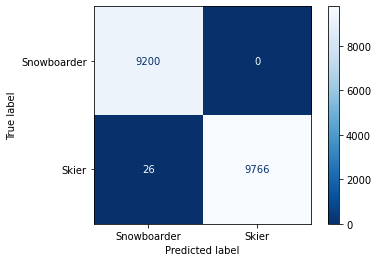

In [117]:
# print out classification metrics for analysis
model_confusion_matrix(logr_tvec,X,y)

## Saving Best Model Results

In [118]:
# pull the top score from each model
nb_cvec_model_scores = nb_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
nb_tvec_model_scores = nb_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
rf_cvec_model_scores = rf_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
rf_tvec_model_scores = rf_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
et_cvec_model_scores = et_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
et_tvec_model_scores = et_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
knn_cvec_model_scores = knn_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
knn_tvec_model_scores = knn_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
logr_cvec_model_scores = logr_cvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()
logr_tvec_model_scores = logr_tvec_results.sort_values('mean_test_score',ascending = False).head(1).filter(regex = r'split\d*_test_score').transpose()

In [119]:
# label each model
nb_cvec_model_scores.columns = ['nb cvec']
nb_tvec_model_scores.columns = ['nb tvec']
rf_cvec_model_scores.columns = ['rf cvec']
rf_tvec_model_scores.columns = ['rf tvec']
et_cvec_model_scores.columns = ['et cvec']
et_tvec_model_scores.columns = ['et tvec']
knn_cvec_model_scores.columns = ['knn cvec']
knn_tvec_model_scores.columns = ['knn tvec']
logr_cvec_model_scores.columns = ['logr cvec']
logr_tvec_model_scores.columns = ['logr tvec']

In [120]:
# create a dataframe of the top models scores
best_tests_10000_comments = pd.concat([nb_cvec_model_scores,nb_tvec_model_scores,
                        rf_cvec_model_scores,rf_tvec_model_scores,
                        et_cvec_model_scores,et_tvec_model_scores,
                        knn_cvec_model_scores,knn_tvec_model_scores,
                        logr_cvec_model_scores,logr_tvec_model_scores],axis = 1)

In [121]:
best_tests_10000_comments

,nb cvec,nb tvec,rf cvec,rf tvec,et cvec,et tvec,knn cvec,knn tvec,logr cvec,logr tvec
split0_test_score,0.950777,0.991577,0.767307,0.795736,0.725981,0.753093,0.993946,0.998947,0.996841,0.998684
split1_test_score,0.951040,0.990261,0.789418,0.788365,0.704922,0.779416,0.995525,0.997894,0.998157,0.998421
split2_test_score,0.952080,0.989205,0.767773,0.738020,0.745919,0.833333,0.989995,0.996051,0.993944,0.997367
split3_test_score,0.950764,0.992364,0.789363,0.822801,0.747235,0.824381,0.994997,0.997894,0.997630,0.998420
split4_test_score,0.951553,0.989205,0.767773,0.785940,0.726172,0.779094,0.991838,0.995261,0.994207,0.996314


In [122]:
# save top model scores
best_tests_10000_comments.to_csv('./data/best_tests_10000_comments.csv')